#  Stable Compounds, Proof of Concept

Imports and Data Loading

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from sklearn.preprocessing import OneHotEncoder

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

In [4]:
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score

In [5]:
from sklearn.decomposition import PCA

In [6]:
my_path = './challenge_data/training_data.csv'
df = pd.read_csv(my_path)
df

,formulaA,formulaB,formulaA_elements_AtomicVolume,formulaB_elements_AtomicVolume,formulaA_elements_AtomicWeight,formulaB_elements_AtomicWeight,formulaA_elements_BoilingT,formulaB_elements_BoilingT,formulaA_elements_BulkModulus,formulaB_elements_BulkModulus,...,formulaB_elements_Row,formulaA_elements_ShearModulus,formulaB_elements_ShearModulus,formulaA_elements_SpaceGroupNumber,formulaB_elements_SpaceGroupNumber,avg_coordination_A,avg_coordination_B,avg_nearest_neighbor_distance_A,avg_nearest_neighbor_distance_B,stabilityVec
0,Ac,Ag,37.433086,17.075648,227.000,107.868200,3473.0,2435.0,0.0,100.0,...,5,0.0,30.0,225,225,12.0,12.0,3.99462,2.94195,"[1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0]"
1,Ac,Al,37.433086,16.594425,227.000,26.981539,3473.0,2792.0,0.0,76.0,...,3,0.0,26.0,225,225,12.0,12.0,3.99462,2.85595,"[1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0]"
2,Ac,As,37.433086,21.723966,227.000,74.921600,3473.0,887.0,0.0,22.0,...,4,0.0,0.0,225,166,12.0,3.0,3.99462,2.55790,"[1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0]"
3,Ac,Ba,37.433086,64.969282,227.000,137.327000,3473.0,2143.0,0.0,9.6,...,6,0.0,4.9,225,229,12.0,8.0,3.99462,4.35637,"[1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0]"
4,Ac,Bi,37.433086,35.483459,227.000,208.980400,3473.0,1837.0,0.0,31.0,...,6,0.0,12.0,225,12,12.0,3.0,3.99462,3.11221,"[1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2567,Zr,Th,23.265943,32.865683,91.224,232.038060,4682.0,5093.0,0.0,54.0,...,7,33.0,31.0,194,225,12.0,12.0,3.19147,3.56059,"[1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0]"
2568,Zr,Tl,23.265943,28.640877,91.224,204.383300,4682.0,1746.0,0.0,43.0,...,6,33.0,2.8,194,194,12.0,8.0,3.19147,3.43253,"[1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0]"
2569,Zr,V,23.265943,13.844898,91.224,50.941500,4682.0,3680.0,0.0,160.0,...,4,33.0,47.0,194,229,12.0,8.0,3.19147,2.59229,"[1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0]"
2570,Zr,Xe,23.265943,36952.924020,91.224,131.293000,4682.0,165.0,0.0,0.0,...,5,33.0,0.0,194,225,12.0,12.0,3.19147,4.85032,"[1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0]"


In [7]:
my_path2 = './challenge_data/test_data.csv'
test = pd.read_csv(my_path2)

# Data Ingestion and EDA

In [8]:
# df.iloc[:,:10].hist(figsize=(12,10),bins=50);

In [9]:
# len(pd.unique(df['formulaB']))

Removal of Stability Vector and Features relating to positioning in element table as many other properties are defining 

In [10]:
feature=df.drop(['stabilityVec'], axis=1)

In [11]:
feature2=feature.drop(['formulaA', 'formulaB','formulaA_elements_Column','formulaB_elements_Column',
                      'formulaA_elements_MendeleevNumber','formulaB_elements_MendeleevNumber',
                      'formulaA_elements_Number','formulaB_elements_Number',
                      'formulaA_elements_Row','formulaB_elements_Row'], axis=1)

In [12]:
test2=test.drop(['formulaA', 'formulaB','formulaA_elements_Column','formulaB_elements_Column',
                      'formulaA_elements_MendeleevNumber','formulaB_elements_MendeleevNumber',
                      'formulaA_elements_Number','formulaB_elements_Number',
                      'formulaA_elements_Row','formulaB_elements_Row'], axis=1)

Creation of a heatmap of features

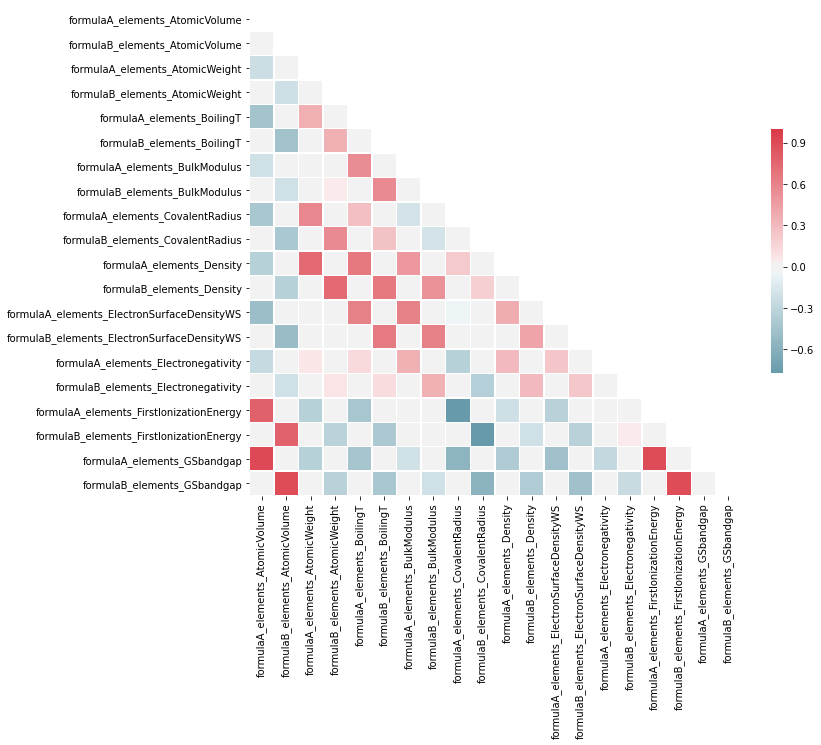

In [13]:
#cell taken from class notebook
# extract the first 20 features
first_twenty = feature2.iloc[:, :20] 
# compute correlation matrix
corr = first_twenty.corr()  
# make mask
mask = np.zeros_like(corr, dtype=np.bool)  
# mask the upper triangle
mask[np.triu_indices_from(mask)] = True  

# create a figure and a subplot
fig, ax = plt.subplots(figsize=(11, 9))  
# costumizing the color map
cmap = sns.diverging_palette(220, 10, as_cmap=True) 
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    center=0,
    linewidth=0.5,
    cbar_kws={'shrink': 0.5}
);

Extraction of the target , conversion to float and into a numpy array

In [14]:
target=df[['stabilityVec']]
target.columns = range(target.shape[1])
target.iloc[:3,:]

,0
0,"[1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0]"
1,"[1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0]"
2,"[1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0]"


In [15]:
b=np.zeros((1,11))
for idx, row in target.iterrows():
    ser=target.iat[idx,0]
    ser=pd.DataFrame(list(ser.split(",")) )
    ser=ser.T
    a=np.zeros((1,11))
    for i,col in enumerate(ser):
        elem=ser.iat[0,i]
        if i==0:
            new=float(elem[1:4])
        if i==10:
            new=float(elem[0:3])
        if i>0 and i<10:
            new=float(elem)
        a[0,i]=new
    b=np.vstack((b, a))

In [16]:
target_np=b[1:]
target_np[:3]

array([[1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

Distribution of class labels training data

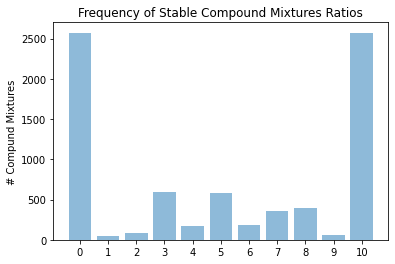

In [17]:
y_pos = [0,1,2,3,4,5,6,7,8,9,10]#np.arange(11)
squares = [np.count_nonzero(x) for x in target_np.T]

plt.bar(y_pos, squares, align='center', alpha=0.5)
plt.xticks(y_pos)
plt.ylabel('# Compund Mixtures')
plt.title('Frequency of Stable Compound Mixtures Ratios')

plt.show()

Functions for counting nonzero samples, and total stable mixed compounds

In [18]:
def nonzero_calc(target):  
    target_min=target[:,1:10]

    nonzs_rowsT=[]
    for rowT in target_min:
        nonz_rowT=(rowT != 0).sum()
        nonzs_rowsT.append(nonz_rowT)
    # print(nonzs_rowsT[:1000])
#     print(np.count_nonzero(nonzs_rowsT))
    return np.count_nonzero(nonzs_rowsT),sum(nonzs_rowsT)

In [19]:
nonzero_calc(target_np)

(1228, 2493)

One-Hot Encoding of Geometry features on complete Dataset (train_test)

In [20]:
comb1=pd.concat((feature2,test2), axis=0)

In [21]:
comb_enc1=comb1[['formulaA_elements_SpaceGroupNumber','formulaB_elements_SpaceGroupNumber',
                 'avg_coordination_A','avg_coordination_B']]

In [22]:
ohe = OneHotEncoder(sparse = False)

In [23]:
ohe.fit(comb_enc1)

# Transforming the "training" data
comb_encdd1 = ohe.transform(comb_enc1)
comb_encdd1

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [24]:
ohe.categories_

[array([  2.,  12.,  14.,  62.,  63.,  64.,  70., 139., 141., 152., 166.,
        194., 217., 225., 227., 229.]),
 array([  2.,  12.,  14.,  62.,  63.,  64.,  70., 139., 141., 152., 166.,
        194., 217., 225., 227., 229.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  8., 12.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  8., 12.])]

Removal and subsequent concatenation of binary features, standardization of remaining features

In [25]:
# cat={}
# for i,col in enumerate(comb1):
#     num=len(comb1[col].unique())
#     cat[i]=num
# cat

In [26]:
binaries=feature2.iloc[:,[42,43,44,45,46,47,48,49,50,51,52,53,74,75]]

In [27]:
bins=binaries.to_numpy()

In [28]:
bin_test=test2.iloc[:,[42,43,44,45,46,47,48,49,50,51,52,53,74,75]]

In [29]:
bin_test2=bin_test.to_numpy()

In [30]:
feature3=feature2.drop(feature2.columns[[42,43,44,45,46,47,48,49,50,51,52,53,74,75,82,83,84,85]],axis=1)

In [31]:
test3=test2.drop(test2.columns[[42,43,44,45,46,47,48,49,50,51,52,53,74,75,82,83,84,85]],axis=1)

In [32]:
scalar=StandardScaler()
scalar.fit(feature3)
X_tr=scalar.transform(feature3)
X_ts=scalar.transform(test3)
# print(X_tr)
# print(X_ts)

In [33]:
X_tr2=np.concatenate((X_tr,bins), axis=1)

In [34]:
X_ts2=np.concatenate((X_ts,bin_test2), axis=1)

In [35]:
X_tr2.shape

(2572, 84)

In [36]:
X_tr3=np.concatenate((X_tr2,comb_encdd1[:2572]), axis=1)

In [37]:
X_ts3=np.concatenate((X_ts2,comb_encdd1[2572:3321]), axis=1)

# Initial Model Construction

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X_tr3, target_np)

!Going forward, use cross-validation instead of these functions## Function for calculating the probability difference of classes (certainty) on test set

In [39]:
def prob_diff(pred_prob):   
    differences=[]
    for index,arr in enumerate(pred_prob):
        if index==0: 
            continue
        if index>9:
            break  
        if index>0 or index<10:
            means=np.mean(arr[:,0]-arr[:,1])
            differences.append(means)
    return np.min(differences)

In [40]:
def prob_diff2(pred_prob):
    mins=[]
    for index,col in enumerate(pred_prob.T):
        if index==0: 
            continue
        if index>9:
            break  
        if index>0 or index<10:
            min_avg=np.mean(col)
            mins.append(min_avg)
    return 1-2*np.min(mins)

Random Forest Base Model

In [41]:
rf_base = RandomForestClassifier(n_estimators=100)
rf_base.fit(X_train, y_train)
print("Random Forest base model: \n", classification_report(y_val, rf_base.predict(X_val)), "\n")
print("Validation score: \n",rf_base.score(X_val, y_val))
print('Minimal Probability difference:', prob_diff(rf_base.predict_proba(X_ts3)))  

Random Forest base model: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       643
           1       1.00      0.06      0.12        16
           2       0.67      0.08      0.14        25
           3       0.76      0.65      0.70       150
           4       0.62      0.23      0.33        35
           5       0.77      0.60      0.68       141
           6       0.73      0.20      0.31        40
           7       0.80      0.41      0.55        80
           8       0.78      0.47      0.59        92
           9       0.83      0.38      0.53        13
          10       1.00      1.00      1.00       643

   micro avg       0.95      0.83      0.89      1878
   macro avg       0.81      0.46      0.54      1878
weighted avg       0.93      0.83      0.86      1878
 samples avg       0.96      0.89      0.91      1878
 

Validation score: 
 0.6267496111975117
Minimal Probability difference: 0.5148464619492656


Multivariate Linear Regression Model

In [42]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_val_pred_cont=lr.predict(X_val)
y_val_pred_cont
y_val_pred=np.where(y_val_pred_cont < 0.5, 0.0, 1.0)
y_val_pred
print("Linear Regression: \n", classification_report(y_val, y_val_pred), "\n")
print("Validation score: \n",lr.score(X_val, y_val_pred))

Linear Regression: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       643
           1       0.00      0.00      0.00        16
           2       0.00      0.00      0.00        25
           3       0.63      0.40      0.49       150
           4       0.33      0.06      0.10        35
           5       0.56      0.29      0.38       141
           6       0.29      0.05      0.09        40
           7       0.40      0.07      0.13        80
           8       0.66      0.27      0.38        92
           9       0.00      0.00      0.00        13
          10       1.00      1.00      1.00       643

   micro avg       0.94      0.76      0.84      1878
   macro avg       0.44      0.29      0.32      1878
weighted avg       0.84      0.76      0.78      1878
 samples avg       0.96      0.83      0.87      1878
 

Validation score: 
 0.1816389102497435


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


Support Vector Machine Model (OneVsRest Wrapper Used to enable multi-class target)

In [43]:
clf = OneVsRestClassifier(SVC(gamma='auto',probability=True)).fit(X_train, y_train)
print("Support Vector Machine: \n", classification_report(y_val, clf.predict(X_val)), "\n")
print("Validation score: \n",clf.score(X_val, y_val))
print('Minimal Probability difference:',prob_diff2(clf.predict_proba(X_ts3)))

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label 0 is present in all training examples.
  str(classes[c]))
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label 10 is present in all training examples.
  str(classes[c]))
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Support Vector Machine: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       643
           1       0.00      0.00      0.00        16
           2       0.00      0.00      0.00        25
           3       0.80      0.37      0.51       150
           4       0.00      0.00      0.00        35
           5       0.82      0.22      0.35       141
           6       0.00      0.00      0.00        40
           7       0.00      0.00      0.00        80
           8       0.50      0.03      0.06        92
           9       0.00      0.00      0.00        13
          10       1.00      1.00      1.00       643

   micro avg       0.98      0.73      0.84      1878
   macro avg       0.37      0.24      0.27      1878
weighted avg       0.83      0.73      0.75      1878
 samples avg       0.99      0.82      0.88      1878
 

Validation score: 
 0.5629860031104199
Minimal Probability difference: 0.9671174181198008


k-Nearest Neighbor Model (Algorithm Choice)

In [44]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print("KNeighbors: \n", classification_report(y_val, knn.predict(X_val)), "\n")
print("Validation score: \n",knn.score(X_val, y_val))
print('Minimal Probability difference:', prob_diff(knn.predict_proba(X_ts3)))

KNeighbors: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       643
           1       0.50      0.06      0.11        16
           2       0.67      0.16      0.26        25
           3       0.73      0.69      0.71       150
           4       0.39      0.26      0.31        35
           5       0.69      0.61      0.65       141
           6       0.45      0.23      0.30        40
           7       0.58      0.42      0.49        80
           8       0.61      0.45      0.52        92
           9       0.40      0.15      0.22        13
          10       1.00      1.00      1.00       643

   micro avg       0.91      0.84      0.87      1878
   macro avg       0.64      0.46      0.51      1878
weighted avg       0.88      0.84      0.85      1878
 samples avg       0.94      0.89      0.90      1878
 

Validation score: 
 0.5800933125972006
Minimal Probability difference: 0.5359145527369826


Alternative: fitting all methods in a series:

In [45]:
# estimators = [
#     ('Random Forest - base model',
#      RandomForestClassifier(n_estimators=100),False),

#     ('Linear regression',
#      LinearRegression(),True),

#     ('Support Vector Machine',
#      OneVsRestClassifier(SVC(gamma='auto',probability=True)),False),

#     ('k-Nearest Neighbor',
#      KNeighborsClassifier(),False)]

In [46]:
# for name, est, y_process in estimators:
#     est.fit(X_train,y_train)
#     if y_process==True:
#         y_pred=est.predict(X_val)
#         y_pred=np.where(y_pred < 0.5, 0.0, 1.0)
#     if y_process==False:
#         y_pred=est.predict(X_val)
#     print(name,"\n", classification_report(y_val,y_pred), "\n")
#     print("Validation score: \n",est.score(X_val, y_val))

Principal Component Analysis (PCA)

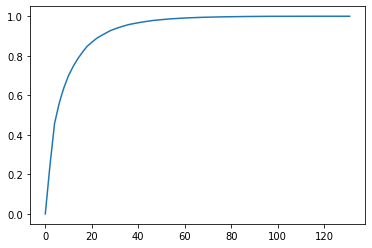

In [47]:
n_samples,n_features= X_tr3.shape[0], X_tr3.shape[1]
fig = plt.figure()
ax = plt.axes()
vs=[]
expls=[]
for v in range(0,min(n_samples, n_features)):
    pca = PCA(n_components=v)
    pca.fit(X_tr3)
    expl=pca.explained_variance_ratio_  
    vs.append(v)
    expls.append(expl.sum())
ax.plot(vs, expls)

# Model Refinement

Random Forest Refinements

Optimizing features and trees

In [48]:
%%time
num_features = ['auto', 132]
n_estimators = [50,75,100,125,150]
scores = dict()
i = 0
for f in num_features:
    for e in n_estimators:
        rf_est = RandomForestClassifier(n_estimators = e, max_features = f)#, random_state = 1738)
        rf_est.fit(X_train, y_train)
        scores[i] = {'recall':recall_score(y_val, rf_est.predict(X_val),average='macro'), 'trees' :e, "feat":f}
        i+=1
pd.DataFrame(scores).T

Wall time: 1min 14s


,recall,trees,feat
0,0.439584,50,auto
1,0.464511,75,auto
2,0.451491,100,auto
3,0.452861,125,auto
4,0.454538,150,auto
5,0.445047,50,132
6,0.450508,75,132
7,0.446691,100,132
8,0.44923,125,132
9,0.453469,150,132


GridSearch for optimal weights

Credit: https://www.kaggle.com/eikedehling/exploring-class-imbalance-resampling-and-weights

In [49]:
middle = np.linspace(0.1, 0.9,10)
minority=np.linspace(0.1, 0.99, 20)
majority=np.linspace(0.01, 0.05, 5)

gsc = GridSearchCV(
    estimator=RandomForestClassifier(n_estimators=100),
    param_grid={
        'class_weight':
#         [{0: x, 1: 1.0-x} for x in weights]
        [[{1: z},{0: x, 1:1.0-x},{0: x, 1: 1.0-x}, {0: x, 1: 1.0-x},
                                          {0: y, 1: 1.0-y},{0: y, 1: 1.0-y}, {0: x, 1: 1.0-x}, {0: y, 1: 1.0-y},
                                          {0: y, 1: 1.0-y}, {0: x, 1: 1.0-x}, {1: z}] 
                                          for x,y,z in zip(minority, middle, majority)
                                         ]
    },
#     scoring='f1'<--was problem before
    scoring='f1_macro'
#     scoring='recall_macro'
   
)
grid_result = gsc.fit(X_train, y_train)

print("Best parameters : %s" % grid_result.best_params_,'score:')

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters : {'class_weight': [{1: 0.05}, {0: 0.2873684210526316, 1: 0.7126315789473684}, {0: 0.2873684210526316, 1: 0.7126315789473684}, {0: 0.2873684210526316, 1: 0.7126315789473684}, {0: 0.4555555555555556, 1: 0.5444444444444444}, {0: 0.4555555555555556, 1: 0.5444444444444444}, {0: 0.2873684210526316, 1: 0.7126315789473684}, {0: 0.4555555555555556, 1: 0.5444444444444444}, {0: 0.4555555555555556, 1: 0.5444444444444444}, {0: 0.2873684210526316, 1: 0.7126315789473684}, {1: 0.05}]} score:


In [50]:
rf_opt = RandomForestClassifier(n_estimators=150,max_features=132,class_weight=[{1: 0.05}, {0: 0.2873684210526316, 1: 0.7126315789473684}, {0: 0.2873684210526316, 1: 0.7126315789473684}, 
                                                                                {0: 0.2873684210526316, 1: 0.7126315789473684}, {0: 0.4555555555555556, 1: 0.5444444444444444}, 
                                                                                {0: 0.4555555555555556, 1: 0.5444444444444444}, {0: 0.2873684210526316, 1: 0.7126315789473684}, 
                                                                                {0: 0.4555555555555556, 1: 0.5444444444444444}, {0: 0.4555555555555556, 1: 0.5444444444444444}, 
                                                                                {0: 0.2873684210526316, 1: 0.7126315789473684}, {1: 0.05}]
                                         )

rf_opt.fit(X_train, y_train)
print("Random Forest: \n", classification_report(y_val, rf_opt.predict(X_val)), "\n")
print("Validation score: \n",rf_opt.score(X_val, y_val))
print('Minimal Probability difference:', prob_diff(rf_opt.predict_proba(X_ts3)))

Random Forest: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       643
           1       1.00      0.06      0.12        16
           2       0.50      0.08      0.14        25
           3       0.74      0.67      0.70       150
           4       0.45      0.14      0.22        35
           5       0.77      0.58      0.66       141
           6       0.60      0.23      0.33        40
           7       0.71      0.34      0.46        80
           8       0.71      0.46      0.56        92
           9       1.00      0.38      0.56        13
          10       1.00      1.00      1.00       643

   micro avg       0.94      0.83      0.88      1878
   macro avg       0.77      0.45      0.52      1878
weighted avg       0.91      0.83      0.85      1878
 samples avg       0.96      0.88      0.91      1878
 

Validation score: 
 0.6034214618973561
Minimal Probability difference: 0.5038718291054739


SVM Model Refinement

'balanced' class weights to strengthen minority classes

In [51]:
svm = OneVsRestClassifier(SVC(gamma='auto',probability=True,class_weight='balanced'))
svm.fit(X_train, y_train)
print("Support Vector Machine: \n", classification_report(y_val, svm.predict(X_val)), "\n")
print("Validation score: \n",svm.score(X_val, y_val))
print('Minimal Probability difference:', prob_diff2(svm.predict_proba(X_ts3)))

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label 0 is present in all training examples.
  str(classes[c]))
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label 10 is present in all training examples.
  str(classes[c]))


Support Vector Machine: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       643
           1       0.31      0.50      0.38        16
           2       0.22      0.44      0.29        25
           3       0.67      0.73      0.70       150
           4       0.29      0.54      0.38        35
           5       0.59      0.72      0.65       141
           6       0.28      0.53      0.37        40
           7       0.48      0.74      0.58        80
           8       0.55      0.66      0.60        92
           9       0.38      0.62      0.47        13
          10       1.00      1.00      1.00       643

   micro avg       0.80      0.90      0.85      1878
   macro avg       0.52      0.68      0.58      1878
weighted avg       0.85      0.90      0.87      1878
 samples avg       0.87      0.93      0.88      1878
 

Validation score: 
 0.5225505443234837
Minimal Probability difference: 0.9588413367236808


GridSearch for kernels

In [52]:
%%time
kernels = ['poly', 'rbf', 'sigmoid']
scores_SVM = dict()
i = 0
for k in kernels:    
        svm2=OneVsRestClassifier(SVC(gamma='auto',probability=True,class_weight='balanced',kernel=k))
        svm2.fit(X_train, y_train)        
        scores_SVM[i] = {'precision':precision_score(y_val, svm2.predict(X_val),average='macro'), 'kernel' :k}
        i+=1
pd.DataFrame(scores_SVM).T

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label 0 is present in all training examples.
  str(classes[c]))
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label 10 is present in all training examples.
  str(classes[c]))
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label 0 is present in all training examples.
  str(classes[c]))
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label 10 is present in all training examples.
  str(classes[c]))
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label 0 is present in all training examples.
  str(classes[c]))
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\multiclass.py:76: UserWarning: Label 10 is present in all training examples.
  str(classes[c]))


Wall time: 1min 54s


,precision,kernel
0,0.550783,poly
1,0.524041,rbf
2,0.376672,sigmoid


KNN Model refinement

In [54]:
#notebook from class
## Calculating Recal scores for multiple "n-neighbors"
recall_scores = {}
for n in [1,2,3,4,5,10,20,50]:
     knn2 = KNeighborsClassifier(n_neighbors=n)
     knn2.fit(X_train, y_train)
     recall_scores[n] = recall_score(y_val, knn2.predict(X_val), average = None)

### Put recall scores into DataFrame
scores_df = pd.DataFrame(recall_scores).T
scores_df
scores_df.columns = [str(i) for i in range(1,12)]
scores_df.index = scores_df.index.astype(str)
scores_df.iloc[:5,:]
        
# ### Optional plot of recall scores
# plt.figure(figsize = (10,10))
# for col in scores_df:
#      if col != 'n_neighbors':
#         plt.plot(scores_df[col], label = col)
    
# plt.ylabel(" Recall Score", fontsize = 12)
# plt.xlabel("n_neighbors", fontsize = 12)
# plt.legend(title = "Class Label",loc='center right',bbox_to_anchor=(1, 0.7));

,1,2,3,4,5,6,7,8,9,10,11
1,1.0,0.3750,0.32,0.660000,0.428571,0.687943,0.325,0.5500,0.565217,0.153846,1.0
2,1.0,0.1250,0.12,0.500000,0.171429,0.411348,0.150,0.3125,0.304348,0.076923,1.0
3,1.0,0.3125,0.16,0.700000,0.257143,0.645390,0.275,0.4625,0.423913,0.153846,1.0
4,1.0,0.0625,0.12,0.533333,0.171429,0.489362,0.200,0.3125,0.358696,0.000000,1.0
5,1.0,0.0625,0.16,0.693333,0.257143,0.609929,0.225,0.4250,0.445652,0.153846,1.0


# Model Evaluation (Model Choice)

Summarizing all model results in a dataframe

In [55]:
res_indv = {'Linear Regression':[ 0.18,0.29,0], 'Support Vector Machine': [0.53,0.25,0.18],
           'Random Forest base model':[ 0.63,0.46,0.51], 'k-nearest Neighbors': [0.58,0.46,0.54],
            'Support Vector Machine balanced':[0.52,0.68,0.96], 'Random Forest optimized': [0.6,0.45,0.5]
           } 

results = pd.DataFrame(res_indv,  index=['validation score', 'macro avg recall', 
                                     'probability difference']) 
results=results.T
results

,validation score,macro avg recall,probability difference
Linear Regression,0.18,0.29,0.00
Support Vector Machine,0.53,0.25,0.18
Random Forest base model,0.63,0.46,0.51
k-nearest Neighbors,0.58,0.46,0.54
Support Vector Machine balanced,0.52,0.68,0.96
Random Forest optimized,0.60,0.45,0.50


Making predictions with the model of choice

In [56]:
predictions=rf_base.predict(X_ts3)

In [57]:
predictions[:10]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

Calculating nonzero samples and total stable compounds

In [58]:
nonzero_calc(predictions)

(277, 473)

Distribution of class labels predictions

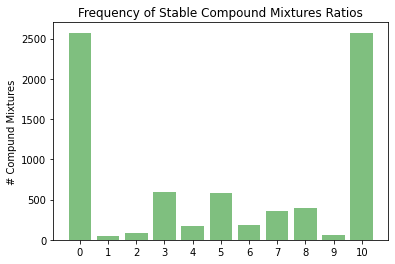

In [59]:
y_pos_pred = [0,1,2,3,4,5,6,7,8,9,10]#np.arange(11)
squares_pred = [np.count_nonzero(x) for x in predictions.T]

plt.bar(y_pos, squares, align='center', alpha=0.5, color='g')
plt.xticks(y_pos)
plt.ylabel('# Compund Mixtures')
plt.title('Frequency of Stable Compound Mixtures Ratios')

plt.show()

Export to csv

In [60]:
pred_pd= pd.DataFrame(predictions)
pred_pd['new']=predictions.tolist()
pred_pd=pred_pd.drop(pred_pd.columns[[0,1,2,3,4,5,6,7,8,9,10]],axis=1)
pred_pd.to_csv('./pred.csv',index=False)
pred_pd

,new
0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...
744,"[1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, ..."
745,"[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
746,"[1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
747,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
